## 25. Simulation Methods

In this we will see that by generating data in a clever way, we can solve a number of problems such as integrating or maximizing a complicated function.  For integration, we will study 3 methods:

- basic Monte Carlo integration
- importance sampling
- Markov chain Monte Carlo (MCMC)

### 25.1 Bayesian Inference Revisited

Simulation methods are specially useful in Bayesian inference so let us briefly review the main ideas.  Given a prior $f(\theta)$ and data $X^n = (X_1, \dots, X_n)$ the posterior density is

$$ f(\theta | X^n) = \frac{\mathcal{L}(\theta) f(\theta)}{ \int \mathcal{L}(u) f(u) \; du} $$

where $\mathcal{L}(\theta)$ is the likelihood function.  The posterior mean is

$$ \overline{\theta} = \int \theta f(\theta | X^n) \; d\theta = \frac{\int \theta \mathcal{L}(\theta) f(\theta) \; d\theta}{\int \mathcal{L}(\theta) f(\theta) \; d\theta} $$

If $\theta = (\theta_1, \dots, \theta_k)$ is multidimensional, then we might be interested in the posterior for one the components, $\theta_1$, say.  This marginal posterior density is

$$ f(\theta_1 | X^n) = \int \int \cdots \int f(\theta_1, \dots, \theta_k | X^n) \; d\theta_2 \cdots d\theta_k$$

which involves high dimensional integration.

You can see that integrals play a big role in Bayesian inference.  When $\theta$ is high dimensional, it may not be feasible to calculate these integrals analytically.  Simulation methods will often be very helpful.

### 25.2 Basic Monte Carlo Integration

Suppose you want to evaluate the integral $I = \int_a^b h(x) dx$ for some function $h$.  If $h$ is an "easy" function like a polynomial or a trigonometric function then we can do the integral in closed form.  In practice, $h$ can be very complicated and there may be no known closed form expression for $I$.  There are many numerical techniques for evaluating $I$ such as Simpson's rule, the trapezoidal rule, Gaussian quadrature and so on.  In some cases these techniques work very well.  But other times they might not work so well.  In particular, it is hard to extend them to higher dimensions.  Monte Carlo integration is another approach to evaluating $I$ which is notable for its simplicity, generality, and scalability.

Let us begin by writing

$$ I = \int_a^b h(x) dx = \int_a^b h(x) (b - a) \frac{1}{b - a} dx = \int_a^b w(x) f(x) dx$$

where $w(x) = h(x)(b - a)$ and $f(x) = 1 / (b - a)$.  Notice that $f$ is the density for a uniform random variable over $(a, b)$.  Hence,

$$ I = \mathbb{E}_f(w(X)) $$

where $X \sim \text{Uniform}(a, b)$.

Suppose we generate $X_1, \dots, X_n \sim \text{Uniform}(a, b)$ where $N$ is large.  By the law of large numbers,

$$ \hat{I} \equiv \frac{1}{N} \sum_{i=1}^N w(X_i) \xrightarrow{\text{P}} \mathbb{E}(w(X)) = I $$

This is the **basic monte carlo integration method**.  We can also compute the standard error of the estimate,

$$ \hat{\text{se}} = \frac{s}{\sqrt{N}} 
\quad \text{where} \quad
s^2 = \frac{\sum_i (Y_i - \hat{I})^2}{N - 1},
\quad Y_i = w(X_i)
$$

A $1 - \alpha$ confidence interval for $I$ is $\hat{I} \pm z_{\alpha / 2} \hat{\text{se}}$.  We can take $N$ as large as we want and hence make the length of the confidence interval very small.

A simple generalization of the basic method is to consider integrals of the form

$$ I = \int h(x) f(x) \; dx $$

where $f(x)$ is a probability density function.  Taking $f$ to be $\text{Uniform}(a, b)$ gives us the special case above.  The only difference is that now we draw $X_1, \dots, X_N \sim f$ and take

$$ \hat{I} \equiv \frac{1}{N} \sum_{i=1}^N h(X_i) $$

as before.

**Example 25.1**.  Let's try this on an example where we know the true answer.  Let $h(x) = x^3$.  Hence, $I = \int_0^1 x^3\;dx = 1/4$.

In [1]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

N = 100000

true_value = 1/4
def h(x):
    return x**3

X = np.random.uniform(low=0, high=1, size=N)
Y = h(X)

I_hat = np.empty(N)
se_hat = np.empty(N)
for n in tqdm_notebook(range(N)):
    I_hat[n] = Y[:n+1].mean()
    if n < 2:
        se_hat[n] = np.inf
    else:
        s2 = np.sum((Y[:n+1] - I_hat[n])**2) / n
        se_hat[n] = np.sqrt(s2 / (n + 1))

        
z = norm.ppf(0.975)

I_lower = I_hat - z * se_hat
I_upper = I_hat + z * se_hat

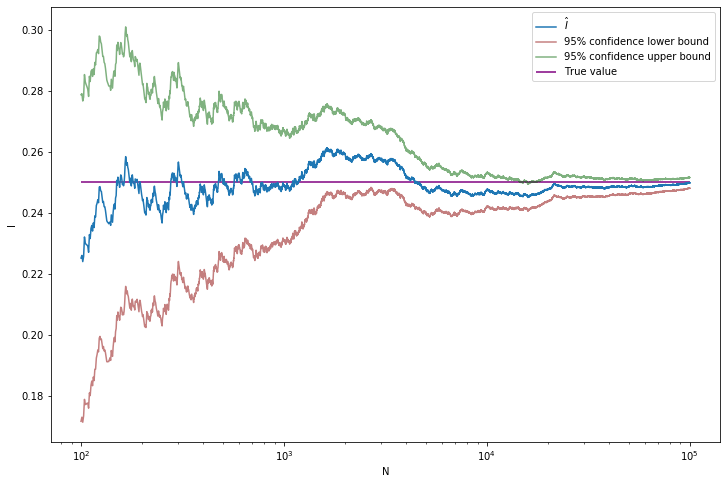

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

nn = np.arange(100, N + 1)

plt.figure(figsize=(12, 8))
plt.plot(nn, I_hat[nn - 1], label=r'$\hat{I}$')
plt.plot(nn, I_lower[nn - 1], label='95% confidence lower bound', color='darkred', alpha=0.5)
plt.plot(nn, I_upper[nn - 1], label='95% confidence upper bound', color='darkgreen', alpha=0.5)
plt.hlines(true_value, xmin=min(nn), xmax=max(nn), label='True value', color='purple')
plt.xlabel('N')
plt.ylabel('I')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

**Example 25.2**.  Let

$$ f(x) = \frac{1}{\sqrt{2 \pi}} e^{-x^2 / 2} $$

be the standard normal PDF.  Suppose we want to compute the CDF at some point,

$$ I = \int_{-\infty}^x f(s) ds = \Phi(x) $$

Of course, you could look up the value in a table or a computing library, but let's use the simulation method instead.

In [3]:
import numpy as np
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook

np.random.seed(0)

N = 100000

true_value = norm.cdf(2)

def h(x):
    return np.where(x < 2, 1, 0)

X = np.random.normal(loc=0.0, scale=1.0, size=N)
Y = h(X)

I_hat = np.empty(N)
se_hat = np.empty(N)
for n in tqdm_notebook(range(N)):
    I_hat[n] = Y[:n+1].mean()
    if n < 2:
        se_hat[n] = np.inf
    else:
        s2 = np.sum((Y[:n+1] - I_hat[n])**2) / n
        se_hat[n] = np.sqrt(s2 / (n + 1))
        
z = norm.ppf(0.975)

I_lower = I_hat - z * se_hat
I_upper = I_hat + z * se_hat

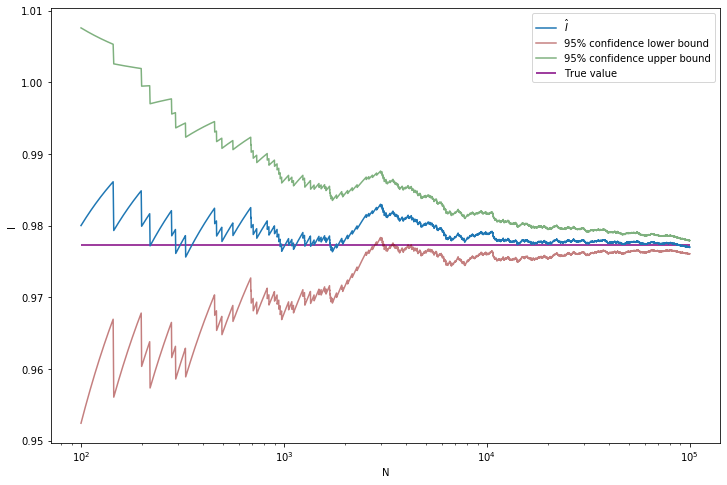

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

nn = np.arange(100, N + 1)

plt.figure(figsize=(12, 8))
plt.plot(nn, I_hat[nn - 1], label=r'$\hat{I}$')
plt.plot(nn, I_lower[nn - 1], label='95% confidence lower bound', color='darkred', alpha=0.5)
plt.plot(nn, I_upper[nn - 1], label='95% confidence upper bound', color='darkgreen', alpha=0.5)
plt.hlines(true_value, xmin=min(nn), xmax=max(nn), label='True value', color='purple')
plt.xlabel('N')
plt.ylabel('I')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

**Example 25.3 (Two Binomials)**.  Let $X \sim \text{Binomial}(n, p_1)$ and $Y \sim \text{Binomial}(n, p_2)$.  We would like to estimate $\delta = p_2 - p_1$.  The MLE is $\hat{\theta} = \hat{p}_2 - \hat{p}_1 = (Y / m) - (X / n)$.  We can get the standard error $\hat{\text{se}}$ using the delta method which yields

$$ \hat{\text{se}} = \sqrt{\frac{\hat{p}_1 (1 - \hat{p}_1)}{n} + \frac{\hat{p}_2 (1 - \hat{p}_2)}{m}} $$

and then construct a confidence interval using $\hat{\delta} \pm z_{\alpha / 2} \hat{\text{se}} $.  Now consider a Bayesian analysis.  Suppose we use the prior $f(p_1, p_2) = f(p_1) f(p_2) = 1$, that is, a flat prior on $(p_1, p_2)$.  The posterior is

$$ f(p_1, p_2 | X, Y) \propto p_1^{X} (1 - p_1)^{n - X} p_2^Y (1 - p_2)^{m - Y}$$

The posterior mean of $\delta$ is

$$ \overline{\delta} = \int_0^1 \int_0^1 \delta(p_1, p_2) f(p_1, p_2 | X, Y) \; dp_1 dp_2 = \int_0^1 \int_0^1 (p_2 - p_1) f(p_1, p_2 | X, Y) \; dp_1 dp_2 $$

If we want the posterior density of $\delta$ we can first get the posterior CDF

$$ F(c | X, Y) = \mathbb{P}(\delta \leq c | X, Y) = \int_A f(p_1, p_2 | X, Y) \; dA $$

where $A = \{ (p_1, p_2) : p_2 - p_1 \leq c \}$.  The density can then be obtained by differentiating $F$.

To avoid these integrals, let's use simulation.  Note that $f(p_1, p_2 | X, Y) = f(p_1 | X) f(p_2 | Y)$ which implies that $p_1$ and $p_2$ are independent under the posterior distribution.  Also, we see that

$$ 
p_1 | X \sim \text{Beta}(X + 1, n - X + 1) 
\quad \text{and} \quad
p_2 | Y \sim \text{Beta}(Y + 1, m - Y + 1) 
$$

Hence, we can simulate $(P_1^{(1)}, P_2^{(1)}), \dots, (P_1^{(N)}, P_2^{(N)})$ by drawing

$$ 
P_1^{(i)} \sim \text{Beta}(X + 1, n - X + 1) 
\quad \text{and} \quad
P_2^{(i)} \sim \text{Beta}(Y + 1, m - Y + 1) 
$$

Now let $\delta^{(i)} = P_2^{(i)} - P_1^{(i)}$.  Then,

$$ \overline{\delta} \approx \frac{1}{N} \sum_i \delta^{(i)} $$

We can also get a 95% posterior interval for $\delta$ by sorting the simulated values, and finding the 2.5% and 97.5% quantiles.  The posterior density $f(\delta | X, Y)$ can be obtained by applying density estimation techniques to the $\delta^{(i)}$ or by simply plotting a histogram.

For example, assume $n = m = 10$, $X = 8$ and $Y = 6$.

In [5]:
import numpy as np
from tqdm import tqdm_notebook

n, m = 10, 10
X, Y = 8, 6

N = 100000

np.random.seed(0)
P1 = np.random.beta(X + 1, n - X + 1, size=N)
P2 = np.random.beta(Y + 1, m - Y + 1, size=N)
delta = P2 - P1

delta_mean = np.empty(N)
delta_lower = np.empty(N)
delta_upper = np.empty(N)
for n in tqdm_notebook(range(N)):
    delta_mean[n] = delta[:n+1].mean()
    if n < 2:
        delta_lower[n], delta_upper[n] = np.inf, np.inf
    else:
        delta_lower[n], delta_upper[n] = np.quantile(delta[:n+1], [0.025, 0.075])

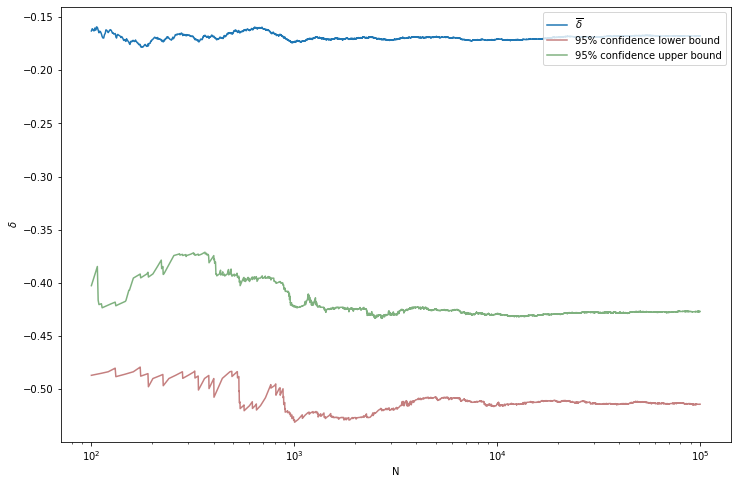

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

nn = np.arange(100, N + 1)

plt.figure(figsize=(12, 8))
plt.plot(nn, delta_mean[nn - 1], label=r'$\overline{\delta}$')
plt.plot(nn, delta_lower[nn - 1], label='95% confidence lower bound', color='darkred', alpha=0.5)
plt.plot(nn, delta_upper[nn - 1], label='95% confidence upper bound', color='darkgreen', alpha=0.5)
plt.xlabel('N')
plt.ylabel(r'$\delta$')
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()

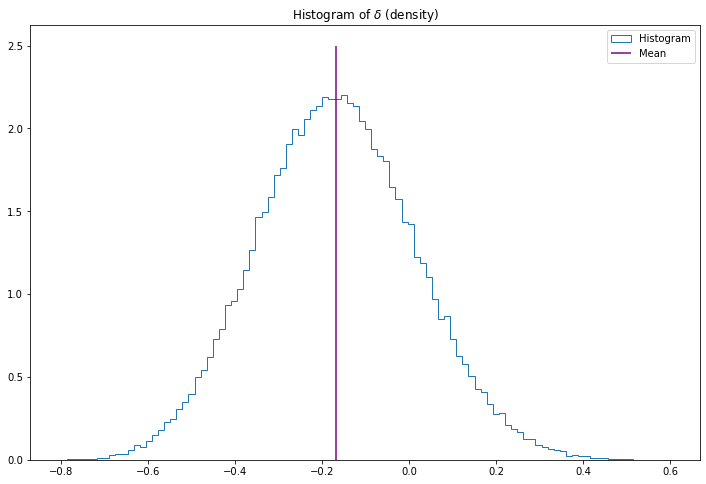

In [7]:
plt.figure(figsize=(12, 8))
plt.hist(delta, bins=100, histtype='step', density=True, label='Histogram')
plt.vlines(delta.mean(), ymin=0, ymax=2.5, label='Mean', color='purple')
plt.title('Histogram of $\delta$ (density)')
plt.legend(loc='upper right')
plt.show()

**Example 25.4 (Dose Response)**.  Suppose we conduct an experiment by giving rats one of ten possible doses of a drug, denoted by $x_1 < x_2 < \cdots < x_{10}$.  For each dose level $x$, we use $n$ rats and observe $Y_i$, the number that die.  Thus we have 10 independent binomials $Y_i \sim \text{Binomial}(n, p_i)$.  Suppose we know from biological considerations that higher doses should have higher probability of death.  Thus, $p_1 \leq p_2 \leq \cdots \leq p_{10}$.  Suppose we want to estimate the dose at which animals have a 50% chance of dying.  This is called the LD50.  Formally, $\delta = x_j$ where

$$ j = \min \{ i: p_i \geq .50 \} $$

Notice that $\delta$ is implicitly a (complicated) function of $p_1, \dots, p_{10}$ so we can write $\delta = g(p_1, \dots, p_{10})$ for some $g$.  This just means that if we know the $p_i$ then we can find $\delta$.  The posterior mean of $\delta$ is

$$ \overline{\delta} = \int \int \cdots \int_A g(p_1, \dots, p_{10}) f(p_1, \dots, p_{10} | Y_1, \dots, Y_{10} ) \; dp_1 dp_2 \dots dp_{10} $$

The integral is over the region of valid parameter values,

$$ A = \{ (p_1, \dots, p_{10}) : p_1 \leq \cdots \leq p_{10} \} $$

Similarly, the posterior CDF of $\delta$ is

$$
F(c | Y_1, \dots, Y_{10}) = \mathbb{P}(\delta \leq c | Y_1, \dots, Y_{10}) = \int \int \cdots \int_B f(p_1, \dots, p_{10} | Y_1, \dots, Y_{10} ) \; dp_1 dp_2 \dots dp_{10}
$$

where the integral is over the valid parameter values given $ \delta \leq c$,

$$ B = A \cap \{ (p_1, \dots, p_{10}) : g(p_1, \dots, p_{10}) \leq c \} $$

We would need to do a 10 dimensional integral over a restricted region $A$.  Instead, let's use simulation.

Let us take a flat prior truncated over $A$.  Except for the truncation, each $P_i$ has once again a Beta distribution.  To draw from the posterior, we do the following steps:

- Draw $P_i \sim \text{Beta}(Y_i + 1, n - Y_i + 1)$, $i = 1, \dots, 10$.
- If $P_1 \leq P_2 \leq \cdots \leq P_{10}$ keep this draw.  Otherwise, throw it away and draw again until you get one you can keep.
- Let $\delta = x_j$ where $j = \min \{ i : P_i > .50 \}$.

We repeat this $N$ times to get $\delta^{(1)}, \dots, \delta^{(N)}$ and take

$$ \mathbb{E}(\delta | Y_1, \dots, Y_{10}) \approx \frac{1}{N} \sum_i \delta^{(i)} $$

$\delta$ is a discrete variable.  We can estimate its probability mass function by 

$$ \mathbb{P}(\delta = x_j | Y_1, \dots, Y_10) \approx \frac{1}{N} I(\delta^{(i)} = j) $$

In [8]:
import numpy as np

n = np.repeat(15, 10)
X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Y = np.array([0, 1, 2, 6, 5, 12, 15, 15, 15, 15])

In [9]:
N = 1000000
p = np.empty((N, 10))
check = np.empty(N, dtype=bool)

np.random.seed(0)
for i in range(10):
    p[:, i] = np.random.beta(Y[i] + 1, n[i] - Y[i] + 1, size=N)
    
check = np.min(np.diff(p), axis=1) >= 0

p = p[check]
N = p.shape[0]

delta = np.empty(N)
for i in range(N):
    delta[i] = X[np.argmax(np.cumsum(p[i, :]) > 0.5)]

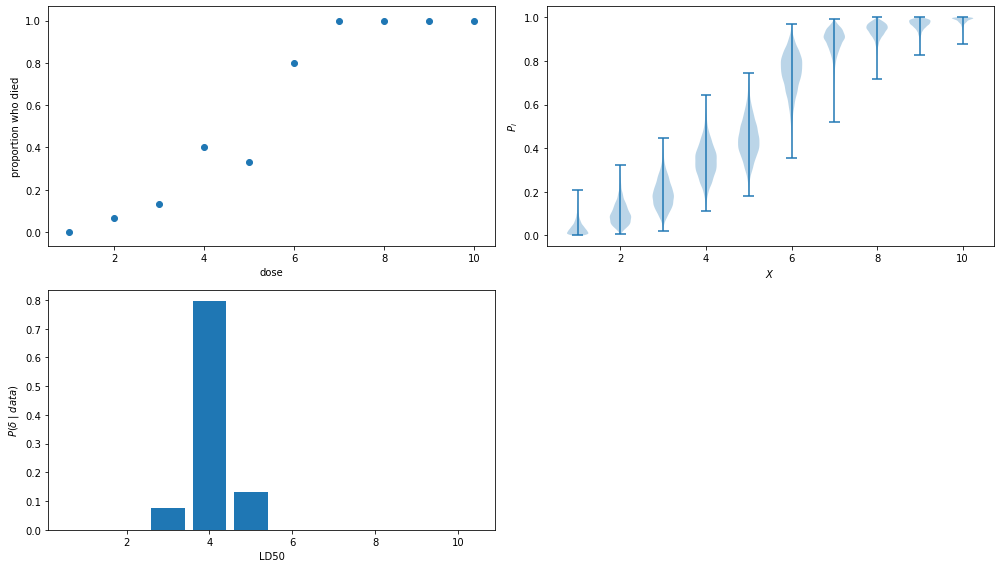

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 8))

ax = plt.subplot(2, 2, 1)
ax.scatter(X, Y / n)
ax.set_xlabel('dose')
ax.set_ylabel('proportion who died')

ax = plt.subplot(2, 2, 2)
ax.violinplot(p)
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$P_i$')

ax = plt.subplot(2, 2, 3)
ax.bar(X, [(sum(delta == i) / N) for i in X])
ax.set_xlabel('LD50')
ax.set_ylabel('$P(\delta \;|\; data)$')

plt.tight_layout()
plt.show()

### 25.3 Importance Sampling

Consider the integral $I = \int h(x) f(x) dx$ where $f$ is a probability density.  The basic Monte Carlo method involves sampling from $f$.  However, there are cases where we may not know how to sample from $f$.  For example, in Bayesian inference, the posterior density is obtained by multiplying the likelihood $\mathcal{L}(\theta)$ times the prior $f(\theta)$.  There is no guarantee that $f(\theta | x)$ will be a known distribution, such as a Normal or a Gamma.

Importance sampling is a generalization of basic Monte Carlo which overcomes this problem.  Let $g$ be a probability density that we know how to simulate from.  Then

$$ I = \int h(x) f(x) \; dx = \int \frac{h(x) f(x)}{g(x)} g(x) \; dx  = \mathbb{E}_g[Y] $$

where $Y = h(X) f(X) / g(X)$ and the expectation $\mathbb{E}_g[Y]$ is with respect to $g$.  We can simulate $X_1, \dots, X_N \sim g$ and estimate $I$ by

$$ \hat{I} = \frac{1}{N} \sum_i Y_i = \frac{1}{N} \sum_i \frac{h(X_i) f(X_i)}{g(X_i)} $$

This is called **importance sampling**. By the law of large numbers, $\hat{I} \xrightarrow{\text{P}} I$.  However, there is a catch.  It's possible that $\hat{I}$ might have an infinite standard error.  To see why, recall that $I$ is the mean of $w(x) = h(x) f(x) / g(x)$.  The second moment of this quantity is

$$ \mathbb{E}_g[w^2(X)] = \int \left( \frac{h(x) f(x)}{g(x)} \right)^2 g(x) \; dx = \int \frac{h^2(x) f^2(x)}{g(x)} \; dx$$

If $g$ has thinner tails than $f$, this integral might be infinite.  To avoid this, a basic rule in importance sampling is to sample from a density $g$ with thicker tails than $f$.  Also, suppose that $g(x)$ is small over some set $A$ where $f(x)$ is large.  Again, the ratio of $f / g$ could be large leading to a large variance.  This implies that we should $g$ to be similar in shape to $f$.  In summary, a good choice for an importance sampling density $g$ should be similar to $f$ but with thicker tails.  In fact, we can say what the optimal choice of $g$ is.

**Theorem 25.5**.  The choice of $g$ that minimizes the variance of $\hat{I}$ is

$$ g^*(x) = \frac{|h(x)| f(x) }{\int | h(s) | f(s)  ds} $$

**Proof**.  The variance of $w = f h / g$ is:

$$
\begin{align}
\mathbb{E}_g[w^2] - (\mathbb{E}_g[w])^2 &= \int w^(x) g(x) dx - \left( \int w(x) g(x) dx \right)^2 \\
&= \int \frac{h^2(x) f^2(x)}{g^2(x)} g(x) dx - \left( \int \frac{h(x) f(x)}{g(x)} g(x) dx \right)^2 \\
&= \int \frac{h^2(x) f^2(x)}{g^2(x)} g(x) dx - \left( \int h(x) f(x) dx \right)^2
\end{align}
$$

The second integral does not depend on $g$ so we only need to minimize the first integral.  Now, from Jensen's inequality we have

$$ \mathbb{E}_g[W^2] \geq \left(\mathbb{E}_g[|W|]\right)^2 = \left( \int |h(x)| f(x) dx \right)^2 $$

This establishes a lower bound on $\mathbb{E}_g[W^2]$.  However, $\mathbb{E}_{g^*}[W^2]$ equals this lower bound, which proves the claim.

This theorem is interesting but only of theoretical interest.  If we did not know how to sample from $f$ then it is unlikely that we could sample from $g^*$.  In practice, we try to find a thick tailed distribution $g$ which is similar to $f |h|$.